In [1]:
import pandas
import datetime
import urllib
import bs4
import os
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import ticker
import seaborn as sns
import scipy
import feather
%matplotlib inline

In [2]:
#  Here we'll compare SAPS mean location with TEC Boundaries and Min loc!!!
sapsProbFileName = "../data/sapsProbs.txt"
sapsProbDF = pandas.read_csv(sapsProbFileName, sep=' ')
# Discard rows where prob of occ is less than 0.2
sapsProbDF = sapsProbDF[ sapsProbDF["probOcc"] >= 0.1 ].reset_index(drop=True)
# sapsProbDF['dst_bin'] = sapsProbDF['dst_bin'].replace(['(-150, -75]', '(-75, -50]'], '(-150, -50]')
sapsProbDF['dst_bin'] = sapsProbDF['dst_bin'].replace(['(-75, -50]'], '(-150, -50]')
sapsProbDF.head()

,dst_bin,sapsMLT,sapsLat,normMLT,normLAT,dataCount,maxCount,MLT,probOcc
0,"(-150, -75]",0.0,54.5,0.0,-3.0,36,333,0,0.108108
1,"(-150, -75]",0.0,55.5,0.0,-2.0,50,333,0,0.150150
2,"(-150, -75]",1.0,53.5,1.0,-4.0,49,333,1,0.147147
3,"(-150, -75]",1.0,54.5,1.0,-3.0,74,333,1,0.222222
4,"(-150, -75]",1.0,55.5,1.0,-2.0,80,333,1,0.240240


In [3]:
rel_perc_cutoff = 0.1

In [4]:
finBndDF = feather.read_dataframe('../data/trghBndDst-fits.feather')
# There is 24 MLT and 0 MLT, remove the discrepancy
finBndDF["mlt"] = finBndDF["mlt"]%24
finBndDF = finBndDF.drop_duplicates()
finBndDF["dst_bin"] = finBndDF["dst_bin"].astype(str)
# Discard MLTs(for each dst_bin) where num observations are low
cntNMltDstPnts = finBndDF.groupby(["dst_bin", "normMLT"]).size().reset_index()
cntNMltDstPnts.columns = ["dst_bin", "normMLT", "cnt"]

cntMaxPnts = cntNMltDstPnts[ ["dst_bin", "cnt"] ].groupby("dst_bin").max().reset_index()
cntMaxPnts.columns = ["dst_bin", "max_cnt"]

cntNMltDstPnts = pandas.merge( cntNMltDstPnts, cntMaxPnts, on=["dst_bin"] )
cntNMltDstPnts["rel_perc"] = cntNMltDstPnts["cnt"]/cntNMltDstPnts["max_cnt"]
cntNMltDstPnts = cntNMltDstPnts[ cntNMltDstPnts["rel_perc"] > rel_perc_cutoff ].reset_index(drop=True)
cntNMltDstPnts = cntNMltDstPnts[ [ "dst_bin", "normMLT", "rel_perc" ] ]
# discard trghMean locations where obse are low
finBndDF = pandas.merge( finBndDF, cntNMltDstPnts, on=["dst_bin", "normMLT"], how="inner" )
print finBndDF.shape


(210382, 21)


In [5]:
trghMeanDF = finBndDF.groupby( ["dst_bin", "normMLT", "mlt"] ).mean().reset_index()
trghMeanDF.columns = ['dst_bin', 'normMLT', 'mlt','mlatEqu_mean','mlatMin_mean',\
                      'mlatPol_mean','mlon_mean','mlonAdjst_mean','tecEqu_mean',\
                      'tecMin_mean','tecPol_mean','timeStr_mean','delTecEqu_mean',\
                      'delTecPol_mean','delMlat_mean','dst_index_mean', 'rel_perc_mean']
trghStdDF = finBndDF.groupby( ["dst_bin", "normMLT", "mlt"] ).std().reset_index()
trghStdDF.columns = ['dst_bin', 'normMLT', 'mlt','mlatEqu_std','mlatMin_std',\
                     'mlatPol_std','mlon_std','mlonAdjst_std','tecEqu_std',\
                     'tecMin_std','tecPol_std','timeStr_std','delTecEqu_std',\
                     'delTecPol_std','delMlat_std','dst_index_std', 'rel_perc_std']
trghMeanDF = pandas.merge( trghMeanDF, trghStdDF, on=["dst_bin", "normMLT", "mlt"] )
trghMeanDF = trghMeanDF.dropna().reset_index(drop=True)
trghMeanDF.head()

,dst_bin,normMLT,mlt,mlatEqu_mean,mlatMin_mean,mlatPol_mean,mlon_mean,mlonAdjst_mean,tecEqu_mean,tecMin_mean,...,mlonAdjst_std,tecEqu_std,tecMin_std,tecPol_std,timeStr_std,delTecEqu_std,delTecPol_std,delMlat_std,dst_index_std,rel_perc_std
0,"(-10, 10]",-3.0,21.0,53.054113,60.292703,66.940324,286.672706,-70.491532,5.767901,3.676802,...,24.636639,2.514069,1.988274,2.378100,164.622063,1.278013,1.195792,3.673999,4.945651,0.0
1,"(-10, 10]",-2.0,22.0,52.136483,59.654314,66.592898,290.170805,-65.224229,5.883296,3.867457,...,25.477006,2.341813,2.055292,2.393627,171.807591,1.209754,1.229347,3.279394,4.919972,0.0
2,"(-10, 10]",-1.0,23.0,51.473615,59.096285,66.233173,294.368718,-58.672263,5.723219,3.700376,...,26.703592,2.152714,1.952053,2.252076,181.237999,1.145823,1.209036,2.807351,5.066290,0.0
3,"(-10, 10]",0.0,0.0,50.996096,58.784787,66.098343,297.961532,-50.176757,5.537713,3.356817,...,26.175764,2.060432,1.756130,2.155382,177.784436,1.219754,1.269629,2.418479,5.026143,0.0
4,"(-10, 10]",1.0,1.0,50.754772,58.641968,66.022368,298.494051,-41.359297,5.466132,3.131758,...,25.429303,2.008888,1.609357,2.039238,172.384114,1.257380,1.259982,2.130538,5.075928,0.0


In [6]:
sapsDF = feather.read_dataframe('../data/processedSaps.feather')
selCols = [ "dateStr", "hour", "sapsLat", "sapsMLT", "sapsVel", "dst_index" ]
sapsDF = sapsDF[selCols]

finBndSapsDF = finBndDF[ ( finBndDF["dateStr"].isin( sapsDF["dateStr"].values ) ) &\
                   ( finBndDF["hour"].isin( sapsDF["hour"].values ) ) ]

finBndNoSapsDF = finBndDF[ ( ~finBndDF["dateStr"].isin( sapsDF["dateStr"].values ) ) |\
                   ( ~finBndDF["hour"].isin( sapsDF["hour"].values ) ) ]

print sapsDF.shape
print finBndSapsDF.shape
print finBndNoSapsDF.shape

(173913, 6)
(63830, 21)
(146552, 21)


In [7]:
trghMeanSapsDF = finBndSapsDF.groupby( ["dst_bin", "normMLT", "mlt"] ).mean().reset_index()
trghMeanSapsDF.columns = ['dst_bin', 'normMLT', 'mlt','mlatEqu_mean','mlatMin_mean',\
                      'mlatPol_mean','mlon_mean','mlonAdjst_mean','tecEqu_mean',\
                      'tecMin_mean','tecPol_mean','timeStr_mean','delTecEqu_mean',\
                      'delTecPol_mean','delMlat_mean','dst_index_mean', 'rel_perc_mean']
trghStdSapsDF = finBndSapsDF.groupby( ["dst_bin", "normMLT", "mlt"] ).std().reset_index()
trghStdSapsDF.columns = ['dst_bin', 'normMLT', 'mlt','mlatEqu_std','mlatMin_std',\
                     'mlatPol_std','mlon_std','mlonAdjst_std','tecEqu_std',\
                     'tecMin_std','tecPol_std','timeStr_std','delTecEqu_std',\
                     'delTecPol_std','delMlat_std','dst_index_std', 'rel_perc_std']
trghMeanSapsDF = pandas.merge( trghMeanSapsDF, trghStdSapsDF, on=["dst_bin", "normMLT", "mlt"] )
trghMeanSapsDF = trghMeanSapsDF.dropna().reset_index(drop=True)
trghMeanSapsDF.head()

,dst_bin,normMLT,mlt,mlatEqu_mean,mlatMin_mean,mlatPol_mean,mlon_mean,mlonAdjst_mean,tecEqu_mean,tecMin_mean,...,mlonAdjst_std,tecEqu_std,tecMin_std,tecPol_std,timeStr_std,delTecEqu_std,delTecPol_std,delMlat_std,dst_index_std,rel_perc_std
0,"(-10, 10]",-3.0,21.0,53.216214,60.071651,66.589780,278.482599,-74.000000,7.418097,4.679814,...,24.901294,2.753036,2.349228,2.336367,173.607658,1.466144,1.213331,3.050703,4.017708,0.0
1,"(-10, 10]",-2.0,22.0,52.066432,59.074207,65.830471,286.846154,-69.923077,6.689487,4.257179,...,25.908186,2.481100,2.003620,2.247053,185.056023,1.449893,1.269157,2.902011,3.792652,0.0
2,"(-10, 10]",-1.0,23.0,51.477961,58.654143,65.557372,296.553964,-60.007641,6.565616,4.106877,...,29.030082,2.378598,2.040552,2.292248,201.758668,1.223799,1.295621,2.513072,4.051198,0.0
3,"(-10, 10]",0.0,0.0,50.739531,58.039173,65.078471,292.003101,-51.252713,6.310233,3.767209,...,27.127255,2.356719,1.971886,2.401446,190.927755,1.283083,1.392499,2.195394,4.044628,0.0
4,"(-10, 10]",1.0,1.0,50.021423,57.403908,64.538159,294.849762,-43.369137,6.045819,3.544663,...,25.909189,2.374137,1.817065,2.301255,179.855952,1.243888,1.288514,1.842682,3.847960,0.0


In [8]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

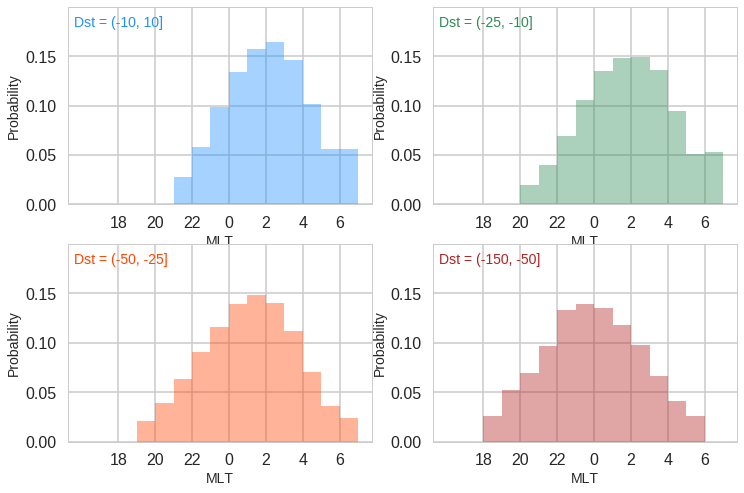

In [9]:
bins = range(-8,8,1)
colDict = {}
colDict['(-10, 10]'] = 'dodgerblue'
colDict['(-25, -10]'] = 'seagreen'
colDict['(-50, -25]'] = 'orangered'
colDict['(-150, -50]'] = 'firebrick'

sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,2,1) )
axArr.append( f.add_subplot(2,2,2) )
axArr.append( f.add_subplot(2,2,3) )
axArr.append( f.add_subplot(2,2,4) )

dstBinArrSorted = ['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-150, -50]']
for binInd, currDstBin in enumerate(dstBinArrSorted):
    selDF = finBndDF[ finBndDF["dst_bin"] == currDstBin]
#     sns.distplot(selDF["normMLT"].values, bins=bins, kde=False,\
#                  hist=True, fit=scipy.stats.gennorm,\
#                  fit_kws={"color": colDict[currDstBin]},\
#                  hist_kws={"color": colDict[currDstBin]}, ax=axArr[binInd])
    sns.distplot(selDF["normMLT"].values, bins=bins, kde=False,\
                 hist=True,norm_hist=True,\
                 fit_kws={"color": colDict[currDstBin]},\
                 hist_kws={"color": colDict[currDstBin]}, ax=axArr[binInd])
#     break
    axArr[binInd].set_xlabel("MLT", fontsize=14)
    axArr[binInd].set_ylabel("Probability", fontsize=14)
    axArr[binInd].set_xticks( range(-6,7,2) )
    axArr[binInd].set_ylim([0,0.2])
    axArr[binInd].set_yticks( numpy.arange(0,0.2,0.05) )
    axArr[binInd].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks)) 
    axArr[binInd].text(0.02, 0.9,  "Dst = " + currDstBin,
            transform=axArr[binInd].transAxes,
            color=colDict[currDstBin], fontsize=14)
plt.savefig("../figs/allBinsHist.pdf",bbox_inches='tight')

In [10]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

In [11]:
# # Need a function to convert MLT to MLON
selTime = datetime.datetime( 2015, 1, 1, 3, 5, 30 )

def convert_mlt_to_mlon(inpMLT, selTime=selTime):
    outMlon = None
    prevDiff = None
    for currMlon in range(0, 360):
        currMLT = aacgm.mltFromYmdhms(\
                          selTime.year, selTime.month,
                                    selTime.day, selTime.hour,
                                    selTime.minute, selTime.second,
                                    currMlon) 
        if abs(currMLT-inpMLT) < 0.1:
            if outMlon is None:
                outMlon = currMlon
                prevDiff = abs(currMLT-inpMLT)
            else:
                if prevDiff > abs(currMLT-inpMLT):
                    outMlon = currMlon
                    prevDiff = abs(currMLT-inpMLT)                
    return outMlon

def saps_pred_func(x, y, dst):    
    (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
        ( 3.04, 2.98e-03, 1.69,\
         -8.53e-04, 4.61, 6.36e-02, -1.28, 3.1e-02,
         8.49e-01, -1.57e-03, 6.69e-01)        
    sigma_x = a_sx + b_sx * dst
    sigma_y = a_sy + b_sy * dst
    xo = a_xo + b_xo * dst
    yo = a_yo + b_yo * dst
    amplitude = a_o + b_o * dst    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g

sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstValArr = []
dstBinArr = []

dstValsInpList = [ 0., -15., -35, -75. ]

for z in range( len( dstValsInpList ) ):
    for x in range( 45, 70 ):
        for y in range( 0, 24 ):
            normLatArr.append( x - 57.5 )
            mltArr.append( y )
            if y < 12:
                currNormMLT = y
            else:
                currNormMLT = y - 24.
            normMltArr.append( currNormMLT )
            latArr.append( x  )
            currDstVal = dstValsInpList[z]
            currProbVal = saps_pred_func(x-57.5, currNormMLT, currDstVal)
            if currProbVal > 0.001:
                probSapsArr.append( currProbVal )
            else:
                probSapsArr.append( 0. )
            dstValArr.append(currDstVal)
        
sapsPredDF["pred_MLT"] = mltArr
sapsPredDF["pred_Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstValArr
print sapsPredDF.head(50)
# Dst High
# sapsPredDFDstHigh = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[1] ]
# sapsPredDFDstHigh["pred_Mlon"] = [ convert_mlt_to_mlon(x, selTime=selTimeDstHigh)\
#                                 for x in sapsPredDFDstHigh["pred_MLT"] ]
# latCntrDstHigh, lonCntrDstHigh = numpy.meshgrid( sapsPredDFDstHigh["pred_Lat"],\
#                                             sapsPredDFDstHigh["pred_Mlon"] )
# probCntrDstHigh = numpy.zeros( latCntrDstHigh.shape )
# print latCntrDstHigh.shape
# cntt = 0
# for i1 in range( probCntrDstHigh.shape[0] ):
#     for i2 in range( probCntrDstHigh.shape[1] ):
#         cntt += 1
#         currProbList = sapsPredDFDstHigh[ (sapsPredDFDstHigh["pred_Lat"] == latCntrDstHigh[i1][i2]) & \
#                                        (sapsPredDFDstHigh["pred_Mlon"] == lonCntrDstHigh[i1][i2]) ]["probSAPS"].tolist()
#         if cntt%5000 == 0:
#             print cntt
#         if len(currProbList) > 0:
#             probCntrDstHigh[i1][i2] = currProbList[0]
#         else:
#             probCntrDstHigh[i1][i2] = numpy.nan#None#numpy.nan
            
# print probCntrDstHigh
# # # Dst Low
# sapsPredDFDstLow = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[0] ]
# print "1111"
# sapsPredDFDstLow["pred_Mlon"] = [ convert_mlt_to_mlon(x, selTime=selTimeDstLow)\
#                                 for x in sapsPredDFDstLow["pred_MLT"] ]
# latCntrDstLow, lonCntrDstLow = numpy.meshgrid( sapsPredDFDstLow["pred_Lat"],\
#                                             sapsPredDFDstLow["pred_Mlon"] )
# print "2222"
# probCntrDstLow = numpy.zeros( latCntrDstLow.shape )
# print "3333"
# for i1 in range( probCntrDstLow.shape[0] ):
#     for i2 in range( probCntrDstLow.shape[1] ):
#         cntt += 1
#         if cntt%5000 == 0:
#             print cntt
#         currProbList = sapsPredDFDstLow[ (sapsPredDFDstLow["pred_Lat"] == latCntrDstLow[i1][i2]) & \
#                                        (sapsPredDFDstLow["pred_Mlon"] == lonCntrDstLow[i1][i2]) ]["probSAPS"].tolist()
        
#         if len(currProbList) > 0:
#             probCntrDstLow[i1][i2] = currProbList[0]
#         else:
#             probCntrDstLow[i1][i2] = numpy.nan#None#numpy.nan
# print "4444"            
# print probCntrDstLow

    normMLT  normLAT  probSAPS  MLT  Lat  dst_index  pred_MLT  pred_Lat
0       0.0    -12.5       0.0  NaN  NaN        0.0         0        45
1       1.0    -12.5       0.0  NaN  NaN        0.0         1        45
2       2.0    -12.5       0.0  NaN  NaN        0.0         2        45
3       3.0    -12.5       0.0  NaN  NaN        0.0         3        45
4       4.0    -12.5       0.0  NaN  NaN        0.0         4        45
5       5.0    -12.5       0.0  NaN  NaN        0.0         5        45
6       6.0    -12.5       0.0  NaN  NaN        0.0         6        45
7       7.0    -12.5       0.0  NaN  NaN        0.0         7        45
8       8.0    -12.5       0.0  NaN  NaN        0.0         8        45
9       9.0    -12.5       0.0  NaN  NaN        0.0         9        45
10     10.0    -12.5       0.0  NaN  NaN        0.0        10        45
11     11.0    -12.5       0.0  NaN  NaN        0.0        11        45
12    -12.0    -12.5       0.0  NaN  NaN        0.0        12   

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000


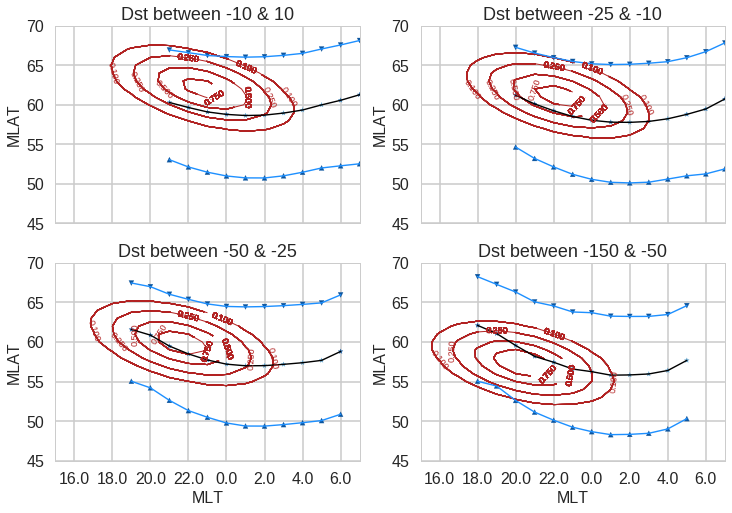

In [12]:
xlim = [-9, 7]
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax4 = f.add_subplot(2,2,1)
ax3 = f.add_subplot(2,2,2)
ax2 = f.add_subplot(2,2,3)
ax1 = f.add_subplot(2,2,4)


sns.set_style("whitegrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Blues"))
sapsSeaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-50]
sapsProbDF15075 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-150, -50]" ]
# sapsProbDF15075.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF15075["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax1, colorbar=False)
trghMLTLat15075 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-150, -50]" ]
trghMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean', marker='*',
              s=25, cmap=seaMap, ax=ax1, vmin=0., vmax=5., sharex=True, colorbar=False)
trghMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=25, cmap=seaMap, marker='^', ax=ax1, vmin=0., vmax=5., colorbar=False)
trghMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=25, cmap=seaMap, marker='v', ax=ax1, vmin=0., vmax=5., colorbar=False)
trghMLTLat15075.plot( x='normMLT',
              y='mlatPol_mean', ax=ax1, legend=False,color='dodgerblue')
trghMLTLat15075.plot( x='normMLT',
              y='mlatMin_mean', ax=ax1, legend=False,color='k')
trghMLTLat15075.plot( x='normMLT',
              y='mlatEqu_mean', ax=ax1, legend=False,color='dodgerblue')




ax1.set_ylabel("MLAT", fontsize=16)
ax1.set_xlabel("MLT", fontsize=16)
ax1.set_title( "Dst between -150 & -50", fontsize=18 )
ax1.set_xlim( xlim )
ax1.set_ylim( [45,70] )


# (-50, -25]
sapsProbDF5025 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-50, -25]" ]
# sapsProbDF5025.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF5025["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax2, colorbar=False)
trghMLTLat5025 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-50, -25]" ]
trghMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',marker='*',
              s=25, cmap=seaMap, ax=ax2, vmin=0., vmax=5., colorbar=False)
trghMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=25, cmap=seaMap, marker='^', ax=ax2, vmin=0., vmax=5., colorbar=False)
trghMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=25, cmap=seaMap, marker='v', ax=ax2, vmin=0., vmax=5., colorbar=False)
trghMLTLat5025.plot( x='normMLT',
              y='mlatPol_mean', ax=ax2, legend=False,color='dodgerblue')
trghMLTLat5025.plot( x='normMLT',
              y='mlatMin_mean', ax=ax2, legend=False,color='k')
trghMLTLat5025.plot( x='normMLT',
              y='mlatEqu_mean', ax=ax2, legend=False,color='dodgerblue')


ax2.set_ylabel("MLAT", fontsize=16)
ax2.set_xlabel("MLT", fontsize=16)
ax2.set_title( "Dst between -50 & -25", fontsize=18 )
ax2.set_xlim( xlim )
ax2.set_ylim( [45,70] )
# (-25, -10]
sapsProbDF2510 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-25, -10]" ]
# sapsProbDF2510.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF2510["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax3, colorbar=False)
trghMLTLat2510 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-25, -10]" ]
trghMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',marker='*',
              s=25, cmap=seaMap, ax=ax3, vmin=0., vmax=5., colorbar=False)
trghMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=25, cmap=seaMap, marker='^', ax=ax3, vmin=0., vmax=5., colorbar=False)
trghMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=25, cmap=seaMap, marker='v', ax=ax3, vmin=0., vmax=5., colorbar=False)
trghMLTLat2510.plot( x='normMLT',
              y='mlatPol_mean', ax=ax3, legend=False,color='dodgerblue')
trghMLTLat2510.plot( x='normMLT',
              y='mlatMin_mean', ax=ax3, legend=False,color='k')
trghMLTLat2510.plot( x='normMLT',
              y='mlatEqu_mean', ax=ax3, legend=False,color='dodgerblue')

ax3.set_ylabel("MLAT", fontsize=16)
ax3.set_xlabel("MLT", fontsize=16)
ax3.set_title( "Dst between -25 & -10", fontsize=18 )
ax3.set_xlim( xlim )
ax3.set_ylim( [45,70] )
# (-10, 10]
sapsProbDF1010 = sapsProbDF[ sapsProbDF["dst_bin"] == "(-10, 10]" ]
# sapsProbDF1010.plot( kind='scatter',
#               x='normMLT',
#               y='sapsLat',
#               c='probOcc',
#               s=sapsProbDF1010["probOcc"]*50, cmap=sapsSeaMap, vmin=0, vmax=1, ax=ax4, colorbar=False)
trghMLTLat1010 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-10, 10]" ]
trghMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',marker='*',
              s=25, cmap=seaMap, ax=ax4, vmin=0., vmax=5., colorbar=False)
trghMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=25, cmap=seaMap, marker='^', ax=ax4, vmin=0., vmax=5., colorbar=False)
trghMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=25, cmap=seaMap, marker='v', ax=ax4, vmin=0., vmax=5., colorbar=False)
trghMLTLat1010.plot( x='normMLT',
              y='mlatPol_mean', ax=ax4, legend=False,color='dodgerblue')
trghMLTLat1010.plot( x='normMLT',
              y='mlatMin_mean', ax=ax4, legend=False,color='k')
trghMLTLat1010.plot( x='normMLT',
              y='mlatEqu_mean', ax=ax4, legend=False,color='dodgerblue')
                    
ax4.set_ylabel("MLAT", fontsize=16)
ax4.set_xlabel("MLT", fontsize=16)
ax4.set_title( "Dst between -10 & 10", fontsize=18 )
ax4.set_xlim( xlim )
ax4.set_ylim( [45,70] )


selSAPSDF0 = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[0] ]
selSAPSDF1 = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[1] ]
selSAPSDF2 = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[2] ]
selSAPSDF3 = sapsPredDF[ sapsPredDF["dst_index"] == dstValsInpList[3] ]
latCntrDstHigh, lonCntrDstHigh = numpy.meshgrid( selSAPSDF3["pred_Lat"],\
                                             selSAPSDF3["normMLT"] )

probCntrDstHigh0 = numpy.zeros( latCntrDstHigh.shape )
probCntrDstHigh1 = numpy.zeros( latCntrDstHigh.shape )
probCntrDstHigh2 = numpy.zeros( latCntrDstHigh.shape )
probCntrDstHigh3 = numpy.zeros( latCntrDstHigh.shape )
cntt = 0
for i1 in range( probCntrDstHigh0.shape[0] ):
    for i2 in range( probCntrDstHigh0.shape[1] ):
        cntt += 1
        currProbList0 = selSAPSDF0[ (selSAPSDF0["pred_Lat"] == latCntrDstHigh[i1][i2]) & \
                                       (selSAPSDF0["normMLT"] == lonCntrDstHigh[i1][i2]) ]["probSAPS"].tolist()
        currProbList1 = selSAPSDF1[ (selSAPSDF1["pred_Lat"] == latCntrDstHigh[i1][i2]) & \
                                       (selSAPSDF1["normMLT"] == lonCntrDstHigh[i1][i2]) ]["probSAPS"].tolist()
        currProbList2 = selSAPSDF2[ (selSAPSDF2["pred_Lat"] == latCntrDstHigh[i1][i2]) & \
                                       (selSAPSDF2["normMLT"] == lonCntrDstHigh[i1][i2]) ]["probSAPS"].tolist()
        currProbList3 = selSAPSDF3[ (selSAPSDF3["pred_Lat"] == latCntrDstHigh[i1][i2]) & \
                                       (selSAPSDF3["normMLT"] == lonCntrDstHigh[i1][i2]) ]["probSAPS"].tolist()
        if cntt%10000 == 0:
            print cntt
        if len(currProbList0) > 0:
            probCntrDstHigh0[i1][i2] = currProbList0[0]
        else:
            probCntrDstHigh0[i1][i2] = numpy.nan#None#numpy.nan
        if len(currProbList1) > 0:
            probCntrDstHigh1[i1][i2] = currProbList1[0]
        else:
            probCntrDstHigh1[i1][i2] = numpy.nan#None#numpy.nan
        if len(currProbList2) > 0:
            probCntrDstHigh2[i1][i2] = currProbList2[0]
        else:
            probCntrDstHigh2[i1][i2] = numpy.nan#None#numpy.nan
        if len(currProbList3) > 0:
            probCntrDstHigh3[i1][i2] = currProbList3[0]
        else:
            probCntrDstHigh3[i1][i2] = numpy.nan#None#numpy.nan
            
cs1=ax1.contour(lonCntrDstHigh, latCntrDstHigh, probCntrDstHigh3,colors = 'firebrick', linewidths=1.,levels=[0.1, 0.25, 0.5, 0.75, 1])
cs2=ax2.contour(lonCntrDstHigh, latCntrDstHigh, probCntrDstHigh2,colors = 'firebrick', linewidths=1.,levels=[0.1, 0.25, 0.5, 0.75, 1])
cs3=ax3.contour(lonCntrDstHigh, latCntrDstHigh, probCntrDstHigh1,colors = 'firebrick', linewidths=1.,levels=[0.1, 0.25, 0.5, 0.75, 1])
cs4=ax4.contour(lonCntrDstHigh, latCntrDstHigh, probCntrDstHigh0,colors = 'firebrick', linewidths=1.,levels=[0.1, 0.25, 0.5, 0.75, 1])


plt.clabel(cs1, fontsize=9, inline=1)
plt.clabel(cs2, fontsize=9, inline=1)
plt.clabel(cs3, fontsize=9, inline=1)
plt.clabel(cs4, fontsize=9, inline=1)
# convert NormMLT to MLT in xticks
ax1.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
ax2.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
ax3.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
ax4.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))

plt.savefig("../figs/trghBnds-SAPS.pdf",bbox_inches='tight')

In [13]:
trghMeanDF.columns

Index([u'dst_bin', u'normMLT', u'mlt', u'mlatEqu_mean', u'mlatMin_mean',
       u'mlatPol_mean', u'mlon_mean', u'mlonAdjst_mean', u'tecEqu_mean',
       u'tecMin_mean', u'tecPol_mean', u'timeStr_mean', u'delTecEqu_mean',
       u'delTecPol_mean', u'delMlat_mean', u'dst_index_mean', u'rel_perc_mean',
       u'mlatEqu_std', u'mlatMin_std', u'mlatPol_std', u'mlon_std',
       u'mlonAdjst_std', u'tecEqu_std', u'tecMin_std', u'tecPol_std',
       u'timeStr_std', u'delTecEqu_std', u'delTecPol_std', u'delMlat_std',
       u'dst_index_std', u'rel_perc_std'],
      dtype='object')